## **Part 1**

In [1]:
import numpy as np
from data import cond_color
from matplotlib import pyplot as plt

psths = np.load('data/psths.npz')
X, times = psths['X'], psths['times']   # X is a 3D array of shape (n_neurons, n_conditions, n_timepoints)

print('Shape for X', np.shape(psths['X']))
print('Shape for times', np.shape(psths['times']))


Shape for X (182, 108, 130)
Shape for times (130,)


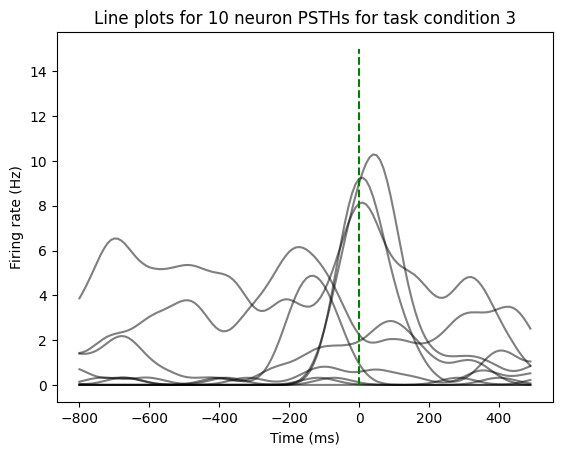

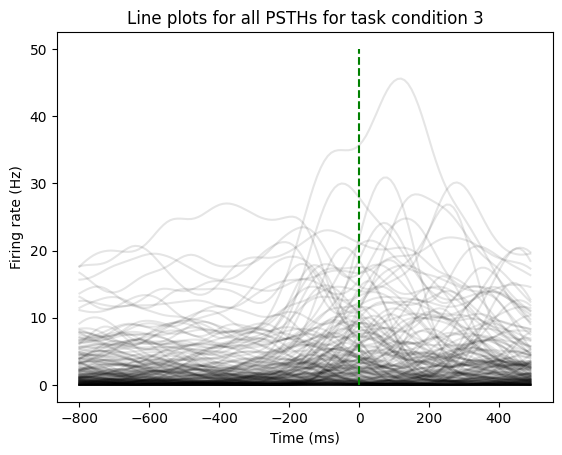

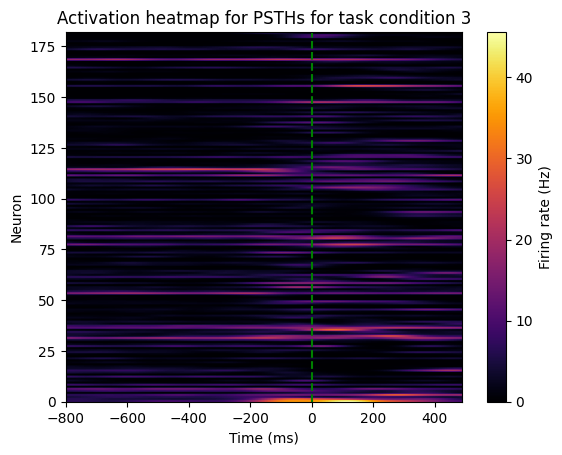

(182, 130)


In [2]:
# Some sample plots from X 

task_condition = 3
average_slice = np.mean(X, axis=1)
slice_data = X[:, task_condition, :]

plt.plot(times, slice_data.T[:, :10], color='black', alpha=0.5)
plt.title('Line plots for 10 neuron PSTHs for task condition {}'.format(task_condition))
plt.vlines(0, 0, 15, color='green', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.show()

plt.plot(times, slice_data.T, color='black', alpha=0.1)
plt.title('Line plots for all PSTHs for task condition {}'.format(task_condition))
plt.vlines(0, 0, 50, color='green', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.show()

# Now plotting with Imshow

plt.imshow(slice_data, aspect='auto', cmap='inferno', extent=[times[0], times[-1], 0, slice_data.shape[0]])
plt.title('Activation heatmap for PSTHs for task condition {}'.format(task_condition))
plt.vlines(0, 0, slice_data.shape[0], color='green', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.colorbar(label='Firing rate (Hz)')
plt.show()

print(slice_data.shape)

Shape for mean_firing_rate (130,)


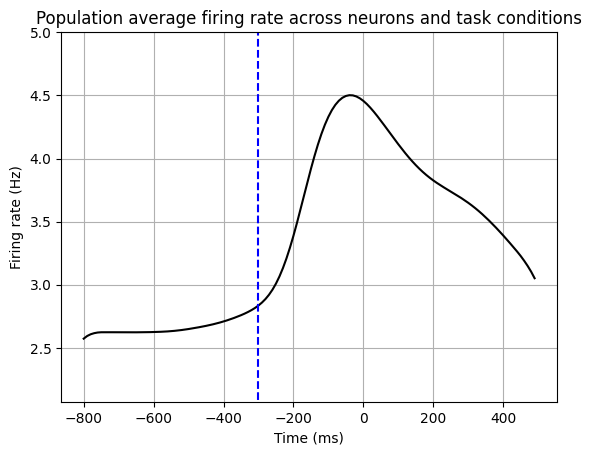

In [3]:
# Plot population average firing rate across neurons and task conditions

mean_firing_rate = np.mean(np.mean(X, axis=0), axis=0)
print('Shape for mean_firing_rate', np.shape(mean_firing_rate))

plt.plot(times, mean_firing_rate, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.ylim(min(mean_firing_rate) - 0.5, max(mean_firing_rate) + 0.5)
plt.title('Population average firing rate across neurons and task conditions')
plt.vlines(-300, 2, 5, color='blue', linestyle='--')
plt.grid()
plt.show()


> Q: What qualitative differences do you notice in the behaviour of PSTH’s in the pre-movement period vs. during or just before hand movement?
> Plot also the population average firing rate as a function of time, obtained by taking the average of the PSTHs across neurons and conditions.

A: From qualititative analysis of the line plots and activation heatmaps - there is a marked difference between the PSTHs after the go cue. Well before the go cue, the neuron activity is stagnant, and somewhat constant. Individual neurons are either in a constant 'on' or 'off' state (corresponding to consistent firing or no firing). About 400 ms before the cue there is a transient stage where neurons change their firing rates. This transience is held until about 200 ms after the go cue after which there is another period of neurons stabilising (presumably as the activity being peformed is constant in that time frame - e.g. moving in a straight line to target). 

The plots are made first with reference to a specific task-condition, then the average firing rate is plotted across tasks and across neurons. 

---

> Q: At what time point (roughly), relative to the movement onset, does this mean rate start to rise significantly above its baseline level (i.e., the approximate firing 
> rate values between, say,-800ms and-600ms, well before the movement onset)? Provide a possible explanation.

From qualitiative analysis - though this can be asserted by using something like an edge-identifying filter like a LoG - around -300 ms is the time when neuron activity changes significantly. This is interesting as it suggests non-causality between the timing of the go cue and the neuron activity. LDS models are best suited for causal inference. If one is to use the model to describe neuron activity, the non-causality can be attributed to mismatched calibration of the measuring instrument. More likely though, the monkey will be anticipating the go cue - and in expectation of the reward, neurons may begin firing well before the actual command. During training, the monkey could have picked up on cues that would indicate that the go cue is about to be given and the training would have induced this anticipation.


## **Part 2**

Shape of max_firing_rates (182,)
Shape of min_firing_rates (182,)


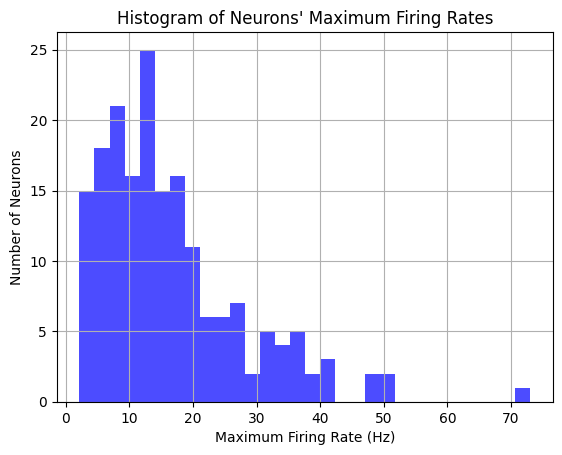

In [4]:
# Calculate the maximum firing rate for each neuron across conditions and time
max_firing_rates = np.max(X, axis=(1, 2))
min_firing_rates = np.min(X, axis=(1, 2))

print('Shape of max_firing_rates', np.shape(max_firing_rates))
print('Shape of min_firing_rates', np.shape(min_firing_rates))

# Plot the histogram
plt.hist(max_firing_rates, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Neurons\' Maximum Firing Rates')
plt.xlabel('Maximum Firing Rate (Hz)')
plt.ylabel('Number of Neurons')
plt.grid()
plt.show()



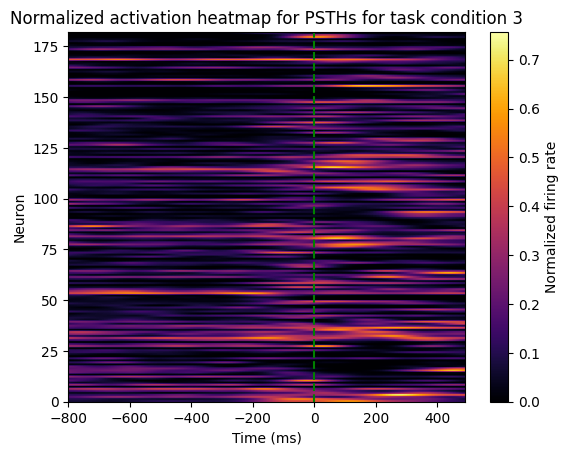

In [5]:
# Normalizing the spike firing data accoridng to min and max
# (a)

X_normalized = (X - min_firing_rates[:, None, None]) / (max_firing_rates[:, None, None] - min_firing_rates[:, None, None] + 5)
slice_normalized = X_normalized[:, task_condition, :]

plt.imshow(slice_normalized, aspect='auto', cmap='inferno', extent=[times[0], times[-1], 0, slice_normalized.shape[0]])
plt.title('Normalized activation heatmap for PSTHs for task condition {}'.format(task_condition))
plt.vlines(0, 0, slice_normalized.shape[0], color='green', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.colorbar(label='Normalized firing rate')
plt.show()

>Q: Why do you think this normalization step will be helpful? 
>(You can come back to this question after going through all exercises.)

A: TBA (NOTE)

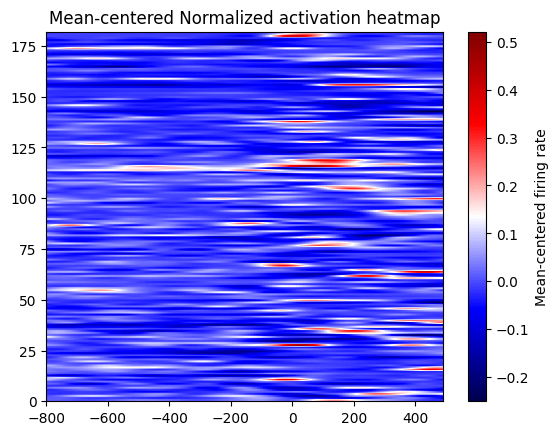

In [6]:
# Mean centering (removing cross condition mean)
# (b)

X_mean_centered = X_normalized - np.mean(X_normalized, axis=1)[:, None, :]
slice_mean_centered = X_mean_centered[:, task_condition, :]
plt.imshow(slice_mean_centered, aspect='auto', cmap='seismic', extent=[times[0], times[-1], 0, slice_mean_centered.shape[0]])
plt.colorbar(label='Mean-centered firing rate')
plt.title('Mean-centered Normalized activation heatmap')
plt.show()


In [7]:
start_index = np.where(times == -150)[0][0]
end_index = np.where(times == 300)[0][0]

X_new = X_mean_centered[:, :, start_index:end_index+1]
times_new = times[start_index:end_index + 1]# Only keep the time points between -150 and 300 ms 
X_new = np.reshape(X_new, (X_new.shape[0], -1)) 
print('Shape of X_new', np.shape(X_new))

Shape of X_new (182, 4968)


In [8]:
# Project the data to the first 12 principal components
#S = np.sum([np.outer(x, x) for x in X_new])

from sklearn.decomposition import PCA
import tqdm 


S = np.matmul(X_new, X_new.T)    
S = S / X_new.shape[0]   
Z_sk = PCA(n_components=12).fit_transform(X_new.T).T
print('Shape of S', np.shape(S))
print('Shape of Z_sk', np.shape(Z_sk))


Shape of S (182, 182)
Shape of Z_sk (12, 4968)


In [9]:
# Calculating eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eigh(S)
print('Shape of eigvals', np.shape(eigvals))
print('Shape of eigvecs', np.shape(eigvecs))


Shape of eigvals (182,)
Shape of eigvecs (182, 182)


In [10]:
M = 12
print(np.shape(eigvals), np.shape(eigvecs))
mle_var = np.mean(eigvals[:-M])

print('MLE sigma for {} PCA components'.format(M), mle_var)

l_array = [np.sqrt(eig - mle_var) for eig in eigvals[-M:]]
print('Shape of l_array', np.shape(l_array))
print(l_array)


V_m = eigvecs[:, -M:]
print('Shape of V_m', np.shape(V_m))
L = np.diag(l_array)
print('Shape of L', np.shape(L))
C = np.matmul(V_m, L)

print('Shape of C', np.shape(C))

(182,) (182, 182)
MLE sigma for 12 PCA components 0.1180841669436586
Shape of l_array (12,)
[0.9620902208545898, 1.1015114601886355, 1.178633044908589, 1.279904849058771, 1.317503583095343, 1.4252285036445065, 1.5648830863329113, 1.6047398126558317, 1.7085857578588999, 2.0659460954680156, 2.2697127561147727, 2.7218746892457135]
Shape of V_m (182, 12)
Shape of L (12, 12)
Shape of C (182, 12)


In [11]:
# Projecting into M space
print('Shape of X_new', np.shape(X_new))
Z_pca = np.matmul(V_m.T, X_new)
print('Shape of Z_pca', np.shape(Z_pca))

np.mean(abs(Z_pca), axis=1)

Shape of X_new (182, 4968)
Shape of Z_pca (12, 4968)


array([0.15276846, 0.17298975, 0.18847616, 0.20617637, 0.21813384,
       0.23300791, 0.2491839 , 0.25737574, 0.27382417, 0.31829943,
       0.37512896, 0.45387445])

## **Part 3**

Shape of pc1 (108, 46)


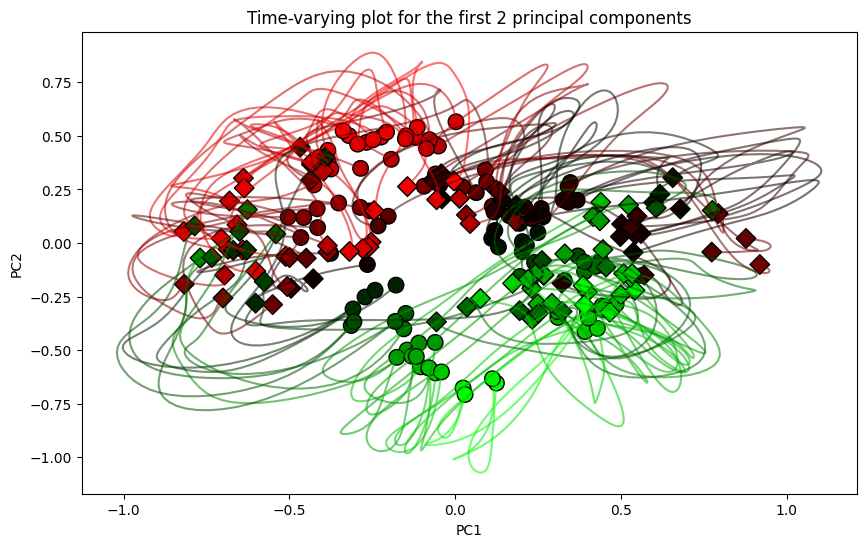

In [12]:
# Making the time-varying plot for the first 2 principal components
from data import cond_color
import numpy as np 



pc1 = Z_pca[-1].reshape(-1, len(times_new))
pc2 = Z_pca[-2].reshape(-1, len(times_new))
print('Shape of pc1', np.shape(pc1))

fig, ax = plt.subplots(figsize=(10, 6))

c_colors = cond_color.get_colors(pc1[:, 0], pc2[:, 0])
cond_color.plot_start(pc1[:, 0], pc2[:, 0], c_colors, 500, ax)
cond_color.plot_end(pc1[:, -1], pc2[:, -1], c_colors, 100, ax)

for xs, ys, c in zip(pc1, pc2, c_colors):
    ax.plot(xs, ys, color=c, alpha=0.55)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Time-varying plot for the first 2 principal components')
plt.show()



# **Part 4**

In [88]:
# Finding gradient with respect to matrix A 

print('Shape of Z_pca', np.shape(Z_pca))   

Z_pca_reshape = Z_pca.reshape(12, X.shape[1], -1)
print('Shape of Z_pca_reshape', np.shape(Z_pca_reshape))

delta_Z_reshape = np.diff(Z_pca_reshape, axis=2)
print('Shape of delta_Z_reshape', np.shape(delta_Z_reshape))

Z_pca_reshape = np.delete(Z_pca_reshape, 0, axis=2)
Z_pca = Z_pca_reshape.reshape(12, -1)

delta_Z = delta_Z_reshape.reshape(12, -1)


Z = Z_pca
delta_Z = delta_Z
print('_'*100)
print('Shape of Z', np.shape(Z))
print('Shape of delta_Z', np.shape(delta_Z))


Shape of Z_pca (12, 4860)
Shape of Z_pca_reshape (12, 108, 45)
Shape of delta_Z_reshape (12, 108, 44)
____________________________________________________________________________________________________
Shape of Z (12, 4752)
Shape of delta_Z (12, 4752)


In [89]:
def construct_H(m = 12):
    # Constructing the Beta array

    H = []

    row, col = 0, 1
    for i in range(m*(m-1)//2):

        H_a = np.zeros((m, m))
        H_a[row, col] = 1
        H_a[col, row] = -1
       
        H.append(list(H_a))

        col += 1
        if col == m:
            row += 1
            col = row + 1

    return H
    

def reconstruct_A(H, b): 
    return np.tensordot(b, H, axes=1)



In [97]:
# Taking derivative of the loss function with respect to A
# An important note here is that W is constructed with Z (with last shape T) which is a mis-match with delta_Z (which has shape T-1)
def gen_W(H:np.ndarray, Z): 
    return np.tensordot(H, Z, axes = 1)


def gen_bQ(W, delta_Z): 
    print('Shape of W', np.shape(W))
    print('Shape of Z', np.shape(delta_Z))
    b_vec = np.tensordot(W, delta_Z, axes=([2, 1], [1, 0]))
    print('Shape of b_vec', np.shape(b_vec))
    Q = np.tensordot(W, W, axes = ([2, 1], [2, 1]))
    print('Shape of Q', np.shape(Q))

    return b_vec, Q

H = construct_H(12)
W = gen_W(H, Z)
b_vec, Q = gen_bQ(W, delta_Z)

beta_pred = np.linalg.inv(Q).dot(b_vec)
print('Shape of beta_pred', np.shape(beta_pred))

A_pred = reconstruct_A(H, beta_pred)

Shape of W (66, 12, 4752)
Shape of Z (12, 4752)
Shape of b_vec (66,)
Shape of Q (66, 66)
Shape of beta_pred (66,)


Text(0.5, 1.0, 'Imshow of A Matrix')

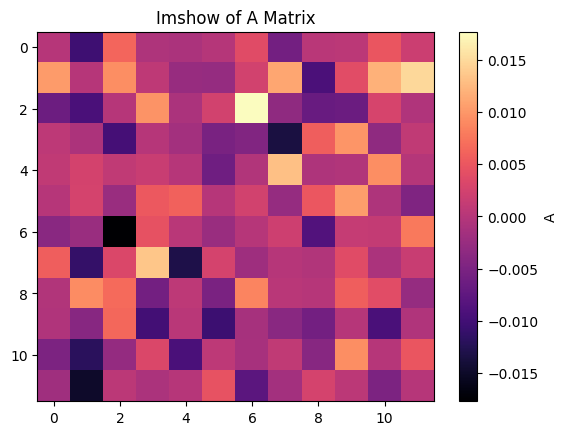

In [109]:
# Imshow of A 

plt.imshow(A_pred, aspect='auto', cmap='magma', interpolation='nearest')
plt.colorbar(label='A')
plt.title('Imshow of A Matrix')

Shape of Z_test (12, 108, 46)
Shape of A_test (12, 12)


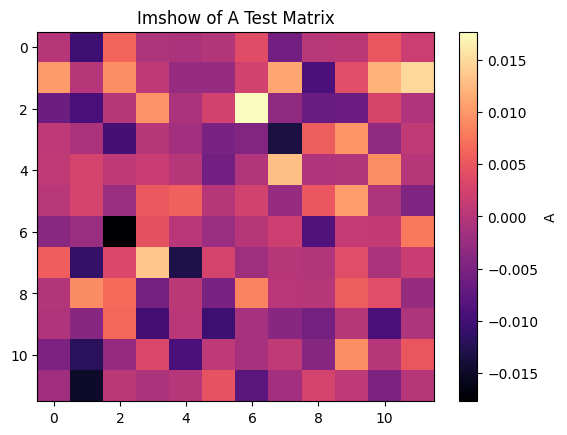

----------------------------------------------------------------------------------------------------
Shape of Z_pca (12, 108, 46)
####################################################################################################
Shape of Z (12, 4860)
Shape of delta_Z (12, 4860)
----------------------------------------------------------------------------------------------------
Shape of H (66, 12, 12)
----------------------------------------------------------------------------------------------------
Shape of W (66, 12, 4860)
----------------------------------------------------------------------------------------------------
Shape of W (66, 12, 4860)
Shape of Z (12, 4860)
Shape of b_vec (66,)
Shape of Q (66, 66)
Shape of b_vec (66,)
Shape of Q (66, 66)
----------------------------------------------------------------------------------------------------
Shape of beta_pred (66,)
----------------------------------------------------------------------------------------------------
Shape of 

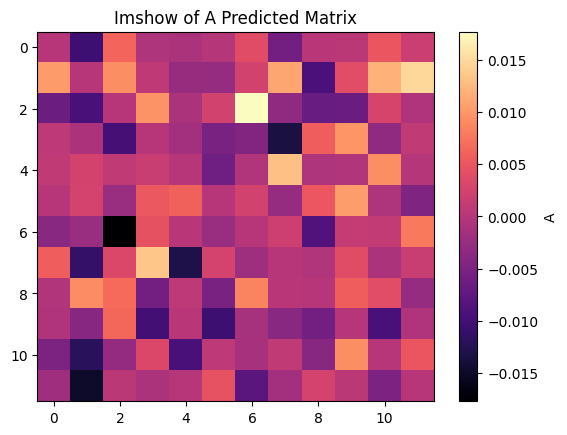

Mean Squared Error for A matrix 7.379494473951553e-10


In [110]:
test_data = np.load('data/test.npz')
Z_test, A_test = test_data['Z_test'], test_data['A_test']

print('Shape of Z_test', np.shape(Z_test))
print('Shape of A_test', np.shape(A_test))


def solve(Z, pca_dim = 12, is_proj = True): 
    """
    Function to solve for A matrix
    """

    print('-'*100)
    print('Shape of Z_pca', np.shape(Z))  
    delta_Z_reshape = np.diff(Z.reshape(pca_dim, X.shape[1], -1), axis=2)
    delta_Z = delta_Z_reshape.reshape(pca_dim, -1)

    Z = np.delete(Z, 0, axis=2)
    Z = Z.reshape(pca_dim, -1)
    print('#'*100)
    print('Shape of Z', np.shape(Z))
    print('Shape of delta_Z', np.shape(delta_Z))
    
    print('-'*100)
    H = construct_H(pca_dim)
    print('Shape of H', np.shape(H))

    print('-'*100)
    W = gen_W(H, Z)
    print('Shape of W', np.shape(W))

    print('-'*100)
    b_vec, Q = gen_bQ(W, delta_Z)
    print('Shape of b_vec', np.shape(b_vec))
    print('Shape of Q', np.shape(Q))

    print('-'*100)
    beta_pred = np.linalg.inv(Q).dot(b_vec)
    print('Shape of beta_pred', np.shape(beta_pred))
    print('-'*100)

    A_pred = reconstruct_A(H, beta_pred)
    print('Shape of A_pred', np.shape(A_pred))
    print('-'*100)

    return A_pred

   

plt.imshow(A_test, aspect='auto', cmap='magma', interpolation='nearest')
plt.title('Imshow of A Test Matrix')
plt.colorbar(label='A')

plt.show()

A_pred = solve(Z_test)
plt.imshow(A_pred, aspect='auto', cmap='magma', interpolation='nearest')
plt.title('Imshow of A Predicted Matrix')
plt.colorbar(label='A')
plt.show()

# Calculating the mean squared error
mse = np.mean((A_test - A_pred)**2)
print('Mean Squared Error for A matrix', mse)


# **Part 5**